# Tarea 4: Redes Convolucionales <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de Respuestas

## Nombre: Guillermo Martínez
Fecha de entrega: 14 de diciembre de 2020

In [ ]:
import os
import sys
import random
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial import distance

import torchvision
import torchvision.transforms as transforms

# Aqui descargamos algunas funciones utiles para resolver la tarea
if not os.path.exists('utils.py'):
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py

from utils import ImageCaptionDataset, train_for_classification, train_for_retrieval

--2020-12-14 01:03:14--  https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7403 (7.2K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.23K  --.-KB/s    in 0s      

2020-12-14 01:03:14 (95.9 MB/s) - ‘utils.py’ saved [7403/7403]



In [ ]:
# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# En caso que se les indique, cambia el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# En caso que se les indique, cambia el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-frvkqf_y/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-frvkqf_y/cc6204
  Created wheel for cc6204: filename=cc6204-0.5.0-cp36-none-any.whl size=5800 sha256=03eb99642a10e95cf211a65da7b72380ff875929b55d63fc25d04964cd27263e
  Stored in directory: /tmp/pip-ephem-wheel-cache-mtpri0eb/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204
Connection stablished


In [ ]:
import matplotlib.pyplot as plt

def plot_results(loss, score1, score1_title='Accuracy', score2=None, score2_title=None):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  ax1.legend(['train-loss'])
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title(score1_title)    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel(score1_title.lower())
  ax2.plot(score1[0], c='b')
  ax2.plot(score1[1], c='g')
  ax2.legend([f'train-{score1_title.lower()}', f'val-{score1_title.lower()}'])
  f2.show()

  if score2:
    f3= plt.figure(3)
    ax3 = f3.add_subplot(111)
    ax3.set_title(score2_title)    
    ax3.set_xlabel('epochs')
    ax3.set_ylabel(score2_title.lower())
    ax3.plot(score2[0], c='b')
    ax3.plot(score2[1], c='g')
    ax3.legend([f'train-{score2_title.lower()}', f'val-{score2_title.lower()}'])
    f3.show()

# Parte 1: Arquitectura Convolucional GoogLeNet (y otras) para CIFAR10

## 1a) Inception Module

In [ ]:
class InceptionModule(nn.Module):
  def __init__(self, 
               in_channels, 
               ch_3x3_reduce=96, 
               ch_5x5_reduce=16,
               ch_3x3=128,
               ch_5x5=32,
               ch_pool_proj=32,
               ch_1x1=64
    ):
    super(InceptionModule, self).__init__()
    # Acá inicializa todos los parámetros
    self.c1 = nn.Conv2d(in_channels, ch_3x3_reduce, (1, 1), stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(ch_3x3_reduce, eps=0.001)

    self.c2 = nn.Conv2d(in_channels, ch_5x5_reduce, (1, 1), stride=1, padding=0)
    self.bn2 = nn.BatchNorm2d(ch_5x5_reduce, eps=0.001)

    self.d1 = nn.Conv2d(ch_3x3_reduce, ch_3x3, (3, 3), stride=1, padding=1)
    self.bnd1 = nn.BatchNorm2d(ch_3x3, eps=0.001)

    self.d2 = nn.Conv2d(ch_5x5_reduce, ch_5x5, (5, 5), stride=1, padding=2)
    self.bnd2 = nn.BatchNorm2d(ch_5x5, eps=0.001)

    self.mp = nn.MaxPool2d((3,3), stride=1, padding=1)

    self.d3 = nn.Conv2d(in_channels, ch_pool_proj, (1, 1), stride=1, padding=0)
    self.bnd3 = nn.BatchNorm2d(ch_pool_proj, eps=0.001)

    self.d4 = nn.Conv2d(in_channels, ch_1x1, (1, 1), stride=1, padding=0)
    self.bnd4 = nn.BatchNorm2d(ch_1x1, eps=0.001)

  def forward(self, x):
    # Calcula la salida como un tensor con cantidad de canales de
    # salida dado por ch_3x3 + ch_5x5 + ch_pool_proj + ch_1x1
    x1 = F.relu(self.bn1(self.c1(x)))
    x2 = F.relu(self.bn2(self.c2(x)))
    x3 = self.mp(x)

    x1 = F.relu(self.bnd1(self.d1(x1)))
    x2 = F.relu(self.bnd2(self.d2(x2)))
    x3 = F.relu(self.bnd3(self.d3(x3)))
    x4 = F.relu(self.bnd4(self.d4(x)))
    
    x = torch.cat([x1, x2, x3, x4], dim=1)

    return x

In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, in_chs, ch_1x1, ch_3x3_red, ch_3x3, ch_5x5_red, ch_5x5, ch_pool_proj = corrector.get_test_data(homework=4, question="1a", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = InceptionModule(in_chs, ch_3x3_red, ch_5x5_red, ch_3x3, ch_5x5, ch_pool_proj, ch_1x1)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
corrector.submit(homework=4, question="1a", test=1, token=token, answer=list(result.size()), time=t)

Correct Test!


## 1b) GoogLeNet

In [ ]:
class GoogLeNet(nn.Module):
  def __init__(self, n_classes, use_aux_logits=True):
    super(GoogLeNet, self).__init__()

    # Define las capas de convolución y pooling de GoogLeNet
    self.conv1 = nn.Conv2d(3, 64, (2, 2), stride=1)
    self.bn1 = nn.BatchNorm2d(64, eps=0.001)
    self.maxpool1 = nn.MaxPool2d((2, 2), stride=1, ceil_mode=True)
    self.conv2 = nn.Conv2d(64, 192, (2, 2), stride=1)
    self.bn2 = nn.BatchNorm2d(192, eps=0.001)
    self.maxpool2 = nn.MaxPool2d((2, 2), stride=1, ceil_mode=True)

    self.inception_3a = InceptionModule(in_channels=192, ch_3x3_reduce=96, ch_5x5_reduce=16, ch_3x3=128, ch_5x5=32, ch_pool_proj=32, ch_1x1=64)
    self.inception_3b = InceptionModule(in_channels=256, ch_3x3_reduce=128, ch_5x5_reduce=32, ch_3x3=192, ch_5x5=96, ch_pool_proj=64, ch_1x1=128)
    self.maxpool3 = nn.MaxPool2d((3, 3), stride=2, ceil_mode=True)
    
    self.inception_4a = InceptionModule(in_channels=480, ch_3x3_reduce=96, ch_5x5_reduce=16, ch_3x3=208, ch_5x5=48, ch_pool_proj=64, ch_1x1=192)
    self.inception_4b = InceptionModule(in_channels=512, ch_3x3_reduce=112, ch_5x5_reduce=24, ch_3x3=224, ch_5x5=64, ch_pool_proj=64, ch_1x1=160)
    self.inception_4c = InceptionModule(in_channels=512, ch_3x3_reduce=128, ch_5x5_reduce=24, ch_3x3=256, ch_5x5=64, ch_pool_proj=64, ch_1x1=128)
    self.inception_4d = InceptionModule(in_channels=512, ch_3x3_reduce=144, ch_5x5_reduce=32, ch_3x3=288, ch_5x5=64, ch_pool_proj=64, ch_1x1=112)
    self.inception_4e = InceptionModule(in_channels=528, ch_3x3_reduce=160, ch_5x5_reduce=32, ch_3x3=320, ch_5x5=128, ch_pool_proj=128, ch_1x1=256)
    self.maxpool4 = nn.MaxPool2d((3, 3), stride=2, ceil_mode=True)
    
    self.inception_5a = InceptionModule(in_channels=832, ch_3x3_reduce=160, ch_5x5_reduce=32, ch_3x3=320, ch_5x5=128, ch_pool_proj=128, ch_1x1=256)
    self.inception_5b = InceptionModule(in_channels=832, ch_3x3_reduce=192, ch_5x5_reduce=48, ch_3x3=384, ch_5x5=128, ch_pool_proj=128, ch_1x1=384)
    self.avgpool = nn.AvgPool2d((7, 7), stride=1)
    self.dropout = nn.Dropout2d(0.4)


    # Decide si usar la clasificación auxiliar
    self.use_aux_logits = use_aux_logits
    if self.use_aux_logits:
      self.aux1_avgpool = nn.AvgPool2d((5, 5), stride=3)
      self.aux1_conv = nn.Conv2d(512, 128, (1, 1), stride=1, padding=0)
      self.aux1_bn = nn.BatchNorm2d(128, eps=0.001)
      self.aux1_fc1 = nn.Linear(2048, 1024)
      self.aux1_fc2 = nn.Linear(1024, n_classes)

      self.aux2_avgpool = nn.AvgPool2d((5, 5), stride=3)
      self.aux2_conv = nn.Conv2d(528, 128, (1, 1), stride=1, padding=0)
      self.aux2_bn = nn.BatchNorm2d(128, eps=0.001)
      self.aux2_fc1 = nn.Linear(2048, 1024)
      self.aux2_fc2 = nn.Linear(1024, n_classes)

    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(1024, n_classes)

  def forward(self, x):
    # Crea una lista para los logits auxiliares si fuera necesario
    if self.use_aux_logits and self.training:
      aux_logits = []
    else:
      aux_logits = None

    # Computa las representaciones internas de la red
    x = self.conv1(x)
    x = F.relu(self.bn1(x))
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = F.relu(self.bn2(x))
    x = self.maxpool2(x)
    x = self.inception_3a(x)
    x = self.inception_3b(x)
    x = self.maxpool3(x)
    x = self.inception_4a(x)

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    if self.use_aux_logits and self.training:
      aux_logit_1 = x.clone()
      aux_logit_1 = self.aux1_avgpool(x)
      aux_logit_1 = self.aux1_conv(aux_logit_1)
      aux_logit_1 = F.relu(self.aux1_bn(aux_logit_1))
      aux_logit_1 = torch.flatten(aux_logit_1, 1)
      aux_logit_1 = F.relu(self.aux1_fc1(aux_logit_1))
      aux_logit_1 = self.aux1_fc2(aux_logit_1)
      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_1)

    # Continúa computando las representaciones internas de la red
    x = self.inception_4b(x)
    x = self.inception_4c(x)
    x = self.inception_4d(x)

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    aux_logit_2 = None
    if self.use_aux_logits and self.training:
      aux_logit_2 = self.aux2_avgpool(x)
      aux_logit_2 = self.aux2_conv(aux_logit_2)
      aux_logit_2 = F.relu(self.aux2_bn(aux_logit_2))
      aux_logit_2 = torch.flatten(aux_logit_2, 1)
      aux_logit_2 = F.relu(self.aux2_fc1(aux_logit_2))
      aux_logit_2 = self.aux2_fc2(aux_logit_2)
      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_2)

    # Continúa computando las representaciones internas de la red
    x = self.inception_4e(x)
    x = self.maxpool4(x)
    x = self.inception_5a(x)
    x = self.inception_5b(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.dropout(x)

    # N x out_size
    logits = self.fc_out(x)
    hidden = logits.clone()

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': logits, 'aux_logits': aux_logits}

In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, n_classes, use_aux_logits = corrector.get_test_data(homework=4, question="1b", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = GoogLeNet(n_classes=n_classes, use_aux_logits=use_aux_logits)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
sizes = [result['hidden'].shape[0]] + list(result['logits'].size()) + [d for a in result['aux_logits'] for d in a.size()]
corrector.submit(homework=4, question="1b", test=1, token=token, answer=sizes, time=t)

Correct Test!


## 1c) Arquitectura Convolucional: VGG16



In [ ]:
class VGGModule(nn.Module):
  def __init__(self, 
               n_conv=2,
               in_channels=3,
               out_channels=64,
               kernel_size=3       
    ):
    super(VGGModule, self).__init__()
    # Acá inicializa todos los parámetros
    self.convs = nn.ModuleList([nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1)])
    for i in range(n_conv - 1):
      self.convs.append(nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1))
    self.bns = nn.ModuleList([nn.BatchNorm2d(out_channels, eps=0.001) for i in range(n_conv)])
    self.fns = nn.ModuleList([nn.ReLU(inplace=True) for i in range(n_conv)])

  def forward(self, x):
    
    for (c, f, b) in zip(self.convs, self.bns, self.fns):
      x = b(f(c(x)))
    
    return x

class VGG16(nn.Module):
  def __init__(self, n_classes, use_aux_logits=True):
    super(VGG16, self).__init__()

    # Define las capas de convolución y pooling de GoogLeNet
    
    self.block1 = VGGModule(n_conv=2, in_channels=3, out_channels=64, kernel_size=3)
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.block2 = VGGModule(n_conv=2, in_channels=64, out_channels=128, kernel_size=3)
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.block3 = VGGModule(n_conv=3, in_channels=128, out_channels=256, kernel_size=3)
    self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.block4 = VGGModule(n_conv=3, in_channels=256, out_channels=512, kernel_size=3)
    self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.block5 = VGGModule(n_conv=3, in_channels=512, out_channels=512, kernel_size=3)
    self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.avgpool = nn.AvgPool2d(kernel_size=1, stride=1)


    # Modified VGG architecture for better performance at CIFAR-10 

    #self.fc1 = nn.Linear(512, 4096)
    #self.bn1 = nn.BatchNorm1d(4096)
    #self.dropout1 = nn.Dropout(0.5)

    #self.fc2 = nn.Linear(4096, 4096)
    #self.bn2 = nn.BatchNorm1d(4096)
    #self.dropout2 = nn.Dropout(0.5)

    #self.fc_out = nn.Linear(4096, n_classes)


    self.fc_out = nn.Linear(512, n_classes)

  def forward(self, x):

    # Computa las representaciones internas de la red
    x = self.block1(x)
    x = self.maxpool1(x)

    x = self.block2(x)
    x = self.maxpool2(x)

    x = self.block3(x)
    x = self.maxpool3(x)

    x = self.block4(x)
    x = self.maxpool4(x)

    x = self.block5(x)
    x = self.maxpool5(x)

    x = self.avgpool(x)

    x = torch.flatten(x, 1)


    # Modified VGG architecture for better performance at CIFAR-10

    #x = F.relu(self.fc1(x))
    #x = self.dropout1(self.bn1(x))

    #x = F.relu(self.fc2(x))
    #x = self.dropout2(self.bn2(x))


    # N x out_size

    logits = self.fc_out(x)
    hidden = logits.clone()

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': logits}

## 1d) Clasificación de Imágenes en CIFAR10

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las celdas tendrás los datos 
# trainset, trainloader y similar para test.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import random

def show_predictions(net, test_dataset):
  net = net.to('cpu').eval()

  w, h = 6, 3
  fig, axs = plt.subplots(h, w, figsize=(3*w,3*h))
  for i in range(h):
    for j in range(w):
      idx = random.randint(0,len(test_dataset))
      T, real = test_dataset[idx]
      
      # Convertimos la imagen en un batch
      X = T.view(1,3,32,32)
      Y = F.softmax(net(X)['logits'], dim=1)
      prob, pred = torch.max(Y, dim=1)
      prob = prob.item()
      pred = pred.item()
      
      T = T / 2 + 0.5
      T = T.permute(1,2,0) 
      
      img = T.numpy()
      title = 'Pred: ' + classes[pred] + ' / Real: ' + classes[real] 
      axs[i,j].set_title(title)
      axs[i,j].set_xticklabels([])
      axs[i,j].set_yticklabels([])
      axs[i,j].imshow(img)

Epoch:1(50000/50000), lr:0.0010000, Loss:1.25121, Train Acc:51.1%, Validating..., Val Acc:62.66%, Avg-Time:185.174s.
Epoch:2(50000/50000), lr:0.0009999, Loss:0.81991, Train Acc:69.3%, Validating..., Val Acc:72.27%, Avg-Time:185.498s.
Epoch:3(50000/50000), lr:0.0009998, Loss:0.63252, Train Acc:76.6%, Validating..., Val Acc:78.81%, Avg-Time:185.623s.
Epoch:4(50000/50000), lr:0.0009994, Loss:0.52752, Train Acc:80.4%, Validating..., Val Acc:78.41%, Avg-Time:185.665s.
Epoch:5(50000/50000), lr:0.0009990, Loss:0.43619, Train Acc:83.4%, Validating..., Val Acc:82.56%, Avg-Time:185.658s.
Epoch:6(50000/50000), lr:0.0009985, Loss:0.37223, Train Acc:85.6%, Validating..., Val Acc:83.14%, Avg-Time:185.609s.
Epoch:7(50000/50000), lr:0.0009978, Loss:0.31003, Train Acc:87.5%, Validating..., Val Acc:84.29%, Avg-Time:185.451s.
Epoch:8(50000/50000), lr:0.0009970, Loss:0.25482, Train Acc:89.2%, Validating..., Val Acc:85.33%, Avg-Time:185.285s.


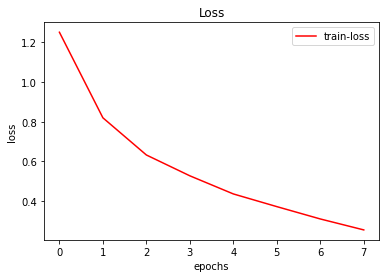

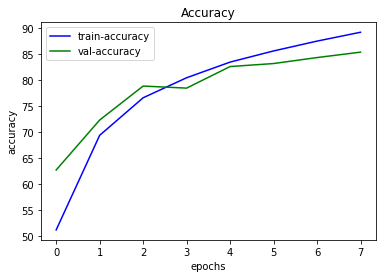

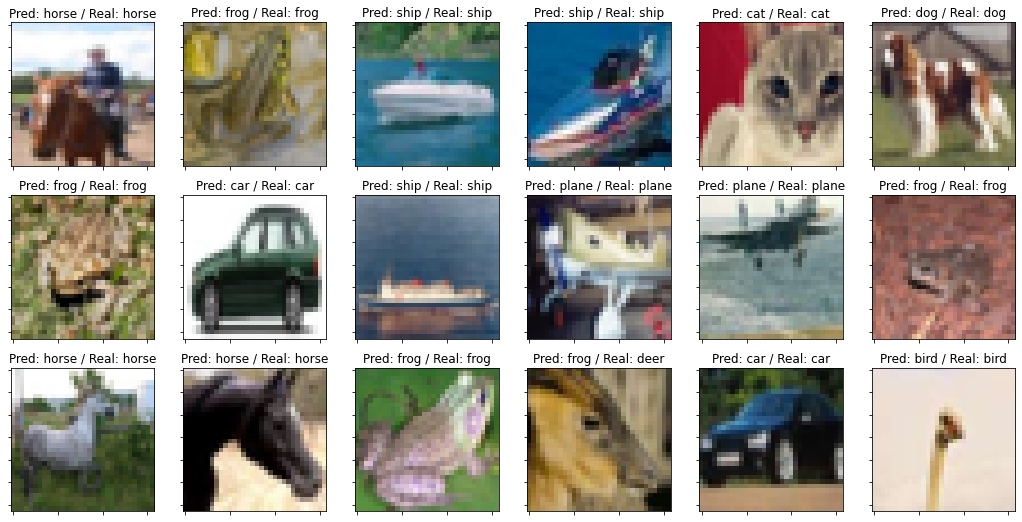

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 8
REPORTS_EVERY = 1

net = GoogLeNet(n_classes=10) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.Adam(net.parameters(), lr=LR) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=2*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader, 
                                           test_loader, optimizer, 
                                           criterion, lr_scheduler=scheduler, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)
show_predictions(net, testset)

Epoch:1(50000/50000), Loss:1.25133, Train Acc:51.5%, Validating..., Val Acc:62.87%, Avg-Time:184.295s.
Epoch:2(50000/50000), Loss:0.81768, Train Acc:69.3%, Validating..., Val Acc:72.57%, Avg-Time:184.440s.
Epoch:3(50000/50000), Loss:0.63202, Train Acc:76.5%, Validating..., Val Acc:78.61%, Avg-Time:184.358s.
Epoch:4(50000/50000), Loss:0.51899, Train Acc:80.7%, Validating..., Val Acc:80.73%, Avg-Time:184.337s.
Epoch:5(50000/50000), Loss:0.42999, Train Acc:83.6%, Validating..., Val Acc:82.13%, Avg-Time:184.228s.
Epoch:6(50000/50000), Loss:0.35562, Train Acc:86.1%, Validating..., Val Acc:83.17%, Avg-Time:184.287s.
Epoch:7(50000/50000), Loss:0.30222, Train Acc:87.8%, Validating..., Val Acc:85.06%, Avg-Time:184.403s.
Epoch:8(50000/50000), Loss:0.24948, Train Acc:89.5%, Validating..., Val Acc:85.78%, Avg-Time:184.487s.


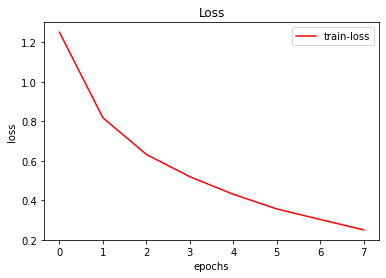

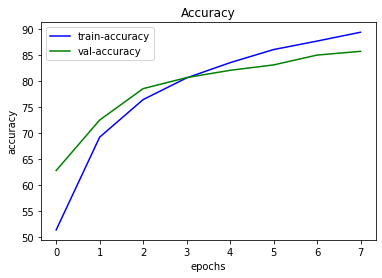

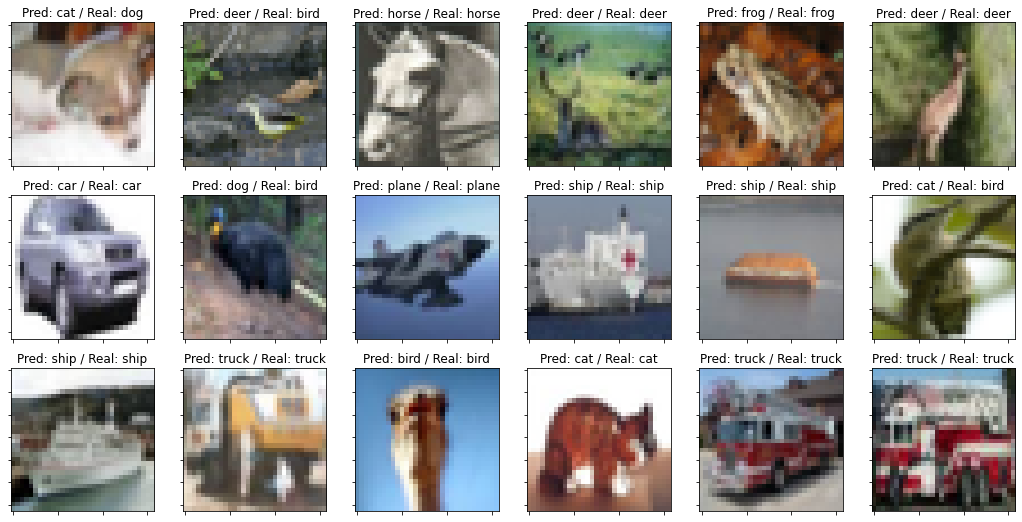

In [ ]:
net2 = GoogLeNet(n_classes=10) # tu modelo de CNN (para clasificar en 10 clases)
optimizer2 = optim.Adam(net2.parameters(), lr=LR) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion2 = nn.CrossEntropyLoss() # función de pérdida
scheduler2 = None

train_loader2 = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader2 = DataLoader(testset, batch_size=2*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss2, acc2 = train_for_classification(net2, train_loader2, 
                                           test_loader2, optimizer2, 
                                           criterion2, lr_scheduler=scheduler2, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss2, acc2)
show_predictions(net2, testset)

Epoch:1(50000/50000), lr:0.0010000, Loss:1.22213, Train Acc:56.4%, Validating..., Val Acc:67.82%, Avg-Time:46.871s.
Epoch:2(50000/50000), lr:0.0009999, Loss:0.74575, Train Acc:74.0%, Validating..., Val Acc:77.28%, Avg-Time:46.879s.
Epoch:3(50000/50000), lr:0.0009998, Loss:0.55477, Train Acc:80.9%, Validating..., Val Acc:79.33%, Avg-Time:46.870s.
Epoch:4(50000/50000), lr:0.0009994, Loss:0.41709, Train Acc:85.6%, Validating..., Val Acc:79.86%, Avg-Time:46.882s.
Epoch:5(50000/50000), lr:0.0009990, Loss:0.31213, Train Acc:89.2%, Validating..., Val Acc:80.65%, Avg-Time:46.853s.
Epoch:6(50000/50000), lr:0.0009985, Loss:0.24232, Train Acc:91.6%, Validating..., Val Acc:80.69%, Avg-Time:46.866s.
Epoch:7(50000/50000), lr:0.0009978, Loss:0.18121, Train Acc:93.7%, Validating..., Val Acc:81.31%, Avg-Time:46.847s.
Epoch:8(50000/50000), lr:0.0009970, Loss:0.13787, Train Acc:95.2%, Validating..., Val Acc:81.98%, Avg-Time:46.831s.
Epoch:9(50000/50000), lr:0.0009961, Loss:0.10775, Train Acc:96.2%, Valid

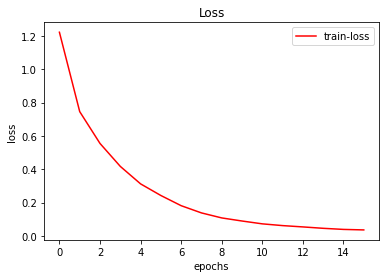

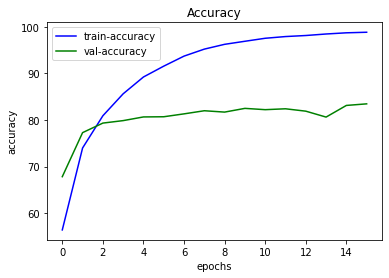

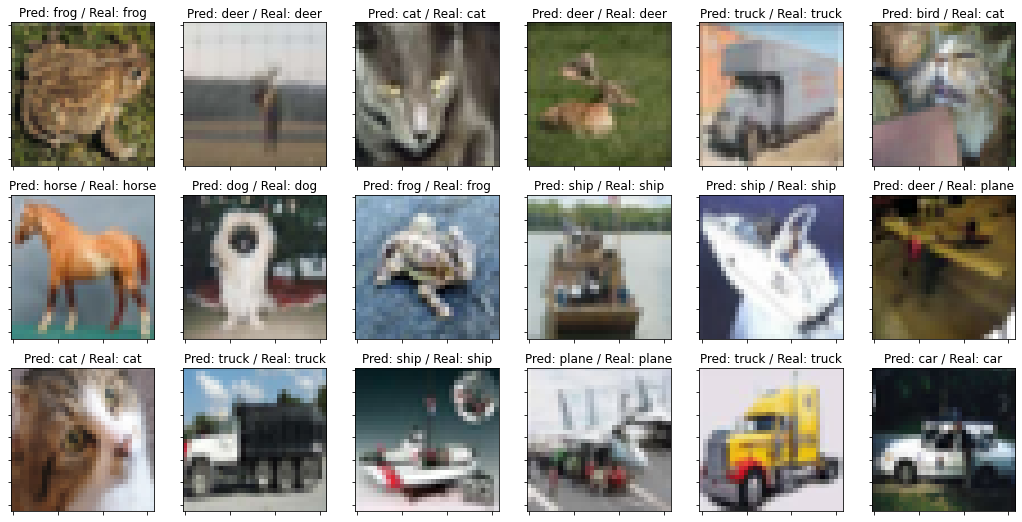

In [ ]:
EPOCHS = 16

net3 = VGG16(n_classes=10) # tu modelo de CNN (para clasificar en 10 clases)
optimizer3 = optim.SGD(net3.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)#, weight_decay=5e-4) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion3 = nn.CrossEntropyLoss() # función de pérdida
scheduler3 = optim.lr_scheduler.CosineAnnealingLR(optimizer3, T_max=200)

train_loader3 = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader3 = DataLoader(testset, batch_size=2*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss3, acc3 = train_for_classification(net3, train_loader3, 
                                           test_loader3, optimizer3, 
                                           criterion3, lr_scheduler=scheduler3, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss3, acc3)
show_predictions(net3, testset)

Epoch:1(50000/50000), lr:0.0010000, Loss:1.62322, Train Acc:37.2%, Validating..., Val Acc:54.73%, Avg-Time:51.154s.
Epoch:2(50000/50000), lr:0.0009999, Loss:1.02908, Train Acc:63.4%, Validating..., Val Acc:65.59%, Avg-Time:51.038s.
Epoch:3(50000/50000), lr:0.0009998, Loss:0.80679, Train Acc:72.3%, Validating..., Val Acc:73.84%, Avg-Time:51.008s.
Epoch:4(50000/50000), lr:0.0009994, Loss:0.65161, Train Acc:77.8%, Validating..., Val Acc:78.04%, Avg-Time:50.992s.
Epoch:5(50000/50000), lr:0.0009990, Loss:0.54851, Train Acc:81.6%, Validating..., Val Acc:81.92%, Avg-Time:50.919s.
Epoch:6(50000/50000), lr:0.0009985, Loss:0.45410, Train Acc:84.8%, Validating..., Val Acc:82.99%, Avg-Time:50.857s.
Epoch:7(50000/50000), lr:0.0009978, Loss:0.37704, Train Acc:87.3%, Validating..., Val Acc:83.10%, Avg-Time:50.822s.
Epoch:8(50000/50000), lr:0.0009970, Loss:0.30752, Train Acc:89.6%, Validating..., Val Acc:84.50%, Avg-Time:50.772s.
Epoch:9(50000/50000), lr:0.0009961, Loss:0.25219, Train Acc:91.6%, Valid

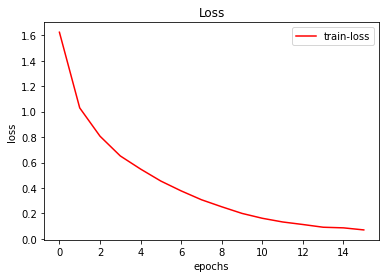

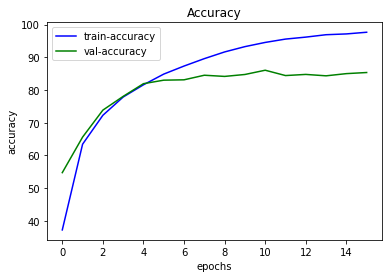

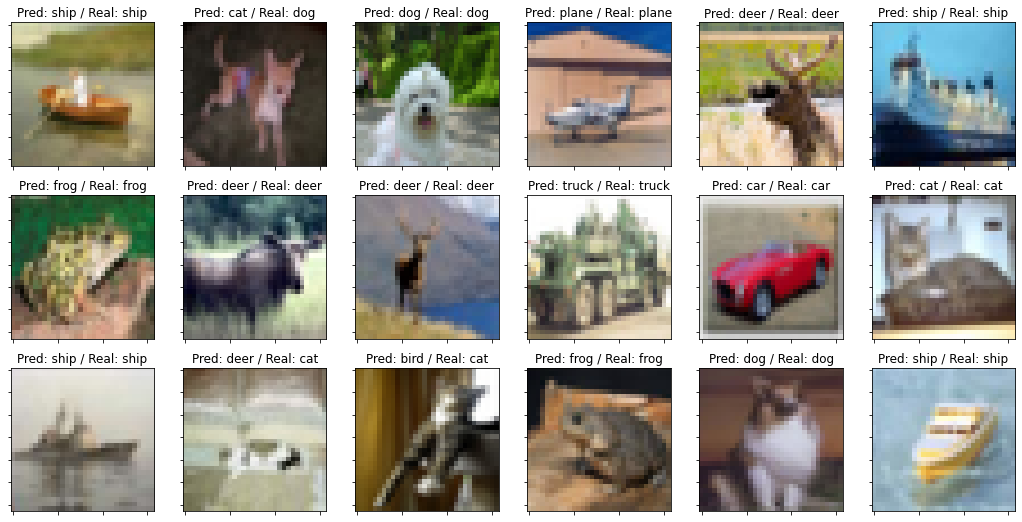

In [ ]:
net4 = VGG16(n_classes=10) # tu modelo de CNN (para clasificar en 10 clases)
optimizer4 = optim.Adam(net4.parameters(), lr=LR)
criterion4 = nn.CrossEntropyLoss() # función de pérdida
scheduler4 = optim.lr_scheduler.CosineAnnealingLR(optimizer4, T_max=200)

train_loader4 = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader4 = DataLoader(testset, batch_size=2*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss4, acc4 = train_for_classification(net4, train_loader4, 
                                           test_loader4, optimizer4, 
                                           criterion4, lr_scheduler=scheduler4, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss4, acc4)
show_predictions(net4, testset)

In [ ]:
# Test (GoogLeNet)
x, y = list(test_loader)[0]
net.cpu()
net.eval()
y_pred = net(x)['logits'].max(dim=1)[1]

# Veamos como se comporta el modelo
print("Correct Test!" if (y==y_pred).sum()/len(x) >= .75 else "Failed Test! [acc]")

Correct Test!


In [ ]:
# Test (VGG16)
x, y = list(test_loader4)[0]
net4.cpu()
net4.eval()
y_pred = net4(x)['logits'].max(dim=1)[1]

# Veamos como se comporta el modelo
print("Correct Test!" if (y==y_pred).sum()/len(x) >= .75 else "Failed Test! [acc]")

Correct Test!


## 1e) Opcional: CIFAR100

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para CIFAR100.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=True,
                                         download=True, transform=transform)

testset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=False,
                                        download=True, transform=transform)

Extracting ./data/cifar100/cifar-100-python.tar.gz to ./data/cifar100
Files already downloaded and verified


Epoch:1(50000/50000), lr:0.0010000, Loss:3.55919, Train Acc:11.2%, Validating..., Val Acc:20.20%, Avg-Time:183.386s.
Epoch:2(50000/50000), lr:0.0009999, Loss:2.70893, Train Acc:25.5%, Validating..., Val Acc:33.42%, Avg-Time:183.417s.
Epoch:3(50000/50000), lr:0.0009998, Loss:2.24636, Train Acc:35.7%, Validating..., Val Acc:41.78%, Avg-Time:183.894s.
Epoch:4(50000/50000), lr:0.0009994, Loss:1.93141, Train Acc:43.3%, Validating..., Val Acc:47.57%, Avg-Time:184.111s.
Epoch:5(50000/50000), lr:0.0009990, Loss:1.70569, Train Acc:48.5%, Validating..., Val Acc:51.35%, Avg-Time:184.378s.
Epoch:6(50000/50000), lr:0.0009985, Loss:1.50990, Train Acc:53.5%, Validating..., Val Acc:54.66%, Avg-Time:184.429s.
Epoch:7(50000/50000), lr:0.0009978, Loss:1.33319, Train Acc:58.0%, Validating..., Val Acc:56.59%, Avg-Time:184.466s.
Epoch:8(50000/50000), lr:0.0009970, Loss:1.18113, Train Acc:61.4%, Validating..., Val Acc:58.66%, Avg-Time:184.606s.


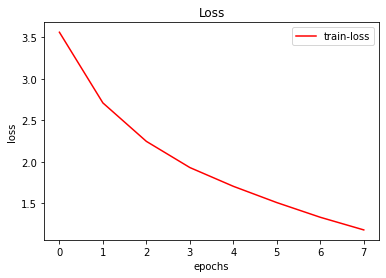

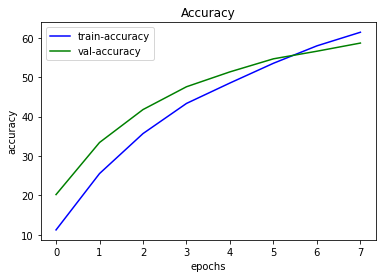

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 8
REPORTS_EVERY = 1

net7 = GoogLeNet(n_classes=100) # tu modelo de CNN (para clasificar en 100 clases)
optimizer7 = optim.Adam(net7.parameters(), lr=LR) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion7 = nn.CrossEntropyLoss() # función de pérdida
scheduler7 = optim.lr_scheduler.CosineAnnealingLR(optimizer7, T_max=200) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader7 = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader7 = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss7, acc7 = train_for_classification(net7, train_loader7, 
                                           test_loader7, optimizer7, 
                                           criterion7, lr_scheduler=scheduler7, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss7, acc7)

# Parte 2: Subtitulado de Imágenes mediante Recuperación de Textos

## 2a) Codificación de Imágenes y Textos

In [ ]:
class ImageEncoding(nn.Module):
  def __init__(self, cnn_model, cnn_out_size, out_size=128, use_last_bn=True):
    super(ImageEncoding, self).__init__()
    self.cnn_model = cnn_model.to('cpu')
    self.cnn_out_size = cnn_out_size

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    self.fc1 = nn.Linear(cnn_out_size, 512)
    self.fc_out = nn.Linear(512, out_size)

    self.dropout1 = nn.Dropout2d(0.3) 
    self.bn1 = nn.BatchNorm1d(512)

    self.use_last_bn = use_last_bn
    if use_last_bn:
      self.bn = nn.BatchNorm1d(out_size)

  def forward(self, x):
    x = self.cnn_model(x)['hidden']
    
    # Compute las capas de su MLP
    x = F.relu(self.fc1(x))
    x = self.dropout1(self.bn1(x))

    x = self.fc_out(x)

    if self.use_last_bn:
      x = self.bn(x)
    
    fc_out = x.clone()

    # En fc_out debe almacenar el encoding en R^d
    return {'logits': fc_out}

In [ ]:
class TextEncoding(nn.Module):
  def __init__(self, text_embedding_size=4096, out_size=128, use_last_bn=True):
    super(TextEncoding, self).__init__()

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    self.fc1 = nn.Linear(text_embedding_size, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc_out = nn.Linear(512, out_size)

    self.dropout1 = nn.Dropout2d(0.3)
    self.dropout2 = nn.Dropout2d(0.2)
    
    self.bn1 = nn.BatchNorm1d(1024)
    self.bn2 = nn.BatchNorm1d(512)

    self.use_last_bn = use_last_bn
    if use_last_bn:
      self.bn = nn.BatchNorm1d(out_size)

  def forward(self, x):
    # Compute las capas de su MLP
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout1(self.bn1(x))

    x = F.relu(self.fc2(x))
    x = self.dropout2(self.bn2(x))

    x = self.fc_out(x)

    if self.use_last_bn:
      x = self.bn(x)
    
    logits = x.clone()
    # En logits debe almacenar el encoding en R^d
    return {'logits': logits}

In [ ]:
# Test
OUT_SIZE = 200

cnn_net = GoogLeNet(n_classes=1024)
i_enc = ImageEncoding(cnn_model=cnn_net, cnn_out_size=1024, out_size=OUT_SIZE)
t_enc = TextEncoding(text_embedding_size=4096, out_size=OUT_SIZE)
i_enc.eval()
t_enc.eval()

# Veamos como se comportan tus encoders
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size()==t_enc(torch.randn(9,4096))['logits'].size()) else "Failed Test [size]")
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size(-1)==OUT_SIZE) else "Failed Test [size]")

Correct Test!
Correct Test!


## 2b) Buenas codificaciones y la *Triplet Loss*

In [ ]:
class TripletLoss(nn.Module):
  def __init__(self, margin=.2, negative='max'):
    super(TripletLoss, self).__init__()
    self.margin = margin
    self.negative = negative

  def forward(self, anchor, positive):
    # Posiblemente lo más simple es partir calculando la distancia Euclideana
    # entre las imagenes ancla y todos los pares (B x B) de representaciones
    # de textos (hint: usa torch.cdist)
    dists = torch.cdist(anchor, positive)

    # Obtener distancias "positivas" de la diagonal
    p_dists = torch.diag(dists)
    p_dist = p_dists.unsqueeze(1).expand_as(dists)


    # Ahora genera un tensor con todos los costos
    # siguiendo la formula vista en la orientación de la tarea
    cost = (torch.max(torch.zeros_like(p_dist), p_dist - dists + self.margin)).clamp(min=0).fill_diagonal_(0)

    # Ahora genera un tensor con todos los costos que se deben agregar
    # dependiendo de la forma de encontrar los negativos
    if self.negative == 'max':
      cost = torch.max(cost, 1)[0]
    elif self.negative == 'random':
      # creamos tansor con los pesos para hacer la selección elatoria
      # (una matriz con 1 en todas las posiciones, excepto la diagonal)
      weight = torch.ones_like(p_dist).fill_diagonal_(0)
      # seleccionamos aleatoriamente un costo negativo por cada anchor
      ids = torch.multinomial(weight, num_samples=anchor.shape[0])
      cost = cost.gather(1, ids)
    elif not self.negative == 'all':
      raise ValueError()
    
    # Retorna el promedio de los costos de todos los triples considerados
    return cost[cost>0].mean()

In [ ]:
# Tests del API del curso para TripletLoss

# Obtengamos algunos parametros para probar tu implementación
for test in [1,2]:
  a, p, m, n  = corrector.get_test_data(homework=4, question="2b", test=test, token=token)
  
  criterion = TripletLoss(margin=m, negative=n)
  result = criterion(torch.tensor(a), torch.tensor(p)).item()

  # Veamos si todo fue OK :)
  corrector.submit(homework=4, question="2b", test=test, token=token, answer=result, time=0)

Correct Test!
Correct Test!


## 2c) Probando tu implementación en Flickr8k

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las dos celdas siguientes
# tendrás los datos en train_flickr_tripletset y similar para val y test
##############################################################################

folder_path = './data/flickr8k'
if not os.path.exists(f'{folder_path}/images'):
  print('\n*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...')
  print('****** Descargando las imágenes...\n')
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip -P $folder_path/images
  print('\n********* Extrayendo las imágenes...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/Flickr8k_Dataset.zip -d $folder_path/images
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://hockenmaier.cs.illinois.edu/8k-pictures.html -P $folder_path/annotations

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

print('Inicializando pytorch Flickr8k dataset')
full_flickr_set = torchvision.datasets.Flickr8k(root=f'{folder_path}/images/Flicker8k_Dataset',
                                                ann_file = f'{folder_path}/annotations/8k-pictures.html',
                                                transform=transform)
print('Creando train, val y test splits...')

train_flickr_set, val_flickr_set, test_flickr_set = [], [], []
for i, item in enumerate(full_flickr_set):
  if i<6000:
    train_flickr_set.append(item)
  elif i<7000:
    val_flickr_set.append(item)
  else:
    test_flickr_set.append(item)


*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...
****** Descargando las imágenes...

--2020-12-14 02:49:28--  https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip
Resolving s06.imfd.cl (s06.imfd.cl)... 192.80.24.186
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115419746 (1.0G) [application/zip]
Saving to: ‘./data/flickr8k/images/Flickr8k_Dataset.zip’

Flickr8k_Dataset.zi   0%[                    ] 911.75K   793KB/s    in 1.1s    

2020-12-14 02:49:31 (793 KB/s) - Connection closed at byte 933632. Retrying.

--2020-12-14 02:49:32--  (try: 2)  https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1115419746 (1.0G), 1114486114 (1.0G) remaining [application/zip]
Saving to: ‘./data/flickr8k/images/Flickr8k_Dataset.zip’

Flickr

In [ ]:
##############################################################################
# Descarguemos representaciones de los textos de 4096 dimensiones
##############################################################################
if not os.path.exists(f'{folder_path}/flickr_cap_encodings_4096d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl -P $folder_path

with open(f'{folder_path}/flickr_cap_encodings_4096d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs, test_cap_encs = pickle.load(f)

# Creamos un dataset para cada uno de los splits con nuestro ImageCaptionDataset
train_flickr_tripletset = ImageCaptionDataset(train_flickr_set, train_cap_encs)
val_flickr_tripletset = ImageCaptionDataset(val_flickr_set, val_cap_encs)
test_flickr_tripletset = ImageCaptionDataset(test_flickr_set, test_cap_encs)

##############################################################################
# Acá termina el código para preparar los datos
##############################################################################

--2020-12-14 02:55:29--  https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl
Resolving s06.imfd.cl (s06.imfd.cl)... 192.80.24.186
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628212160 (599M) [application/octet-stream]
Saving to: ‘./data/flickr8k/flickr_cap_encodings_4096d.pkl’

flickr_cap_encoding 100%[===================>] 599.11M  1.86MB/s    in 1m 41s  

2020-12-14 02:57:10 (5.96 MB/s) - ‘./data/flickr8k/flickr_cap_encodings_4096d.pkl’ saved [628212160/628212160]



Epoch:1(6000/6000), lr:0.0001000, Loss:3.29319, Train MRR:0.09 R@10:19.87%, Validating...MRR:0.12 R@10:29.96% Avg-Time:21.379s.
Epoch:2(6000/6000), lr:0.0001000, Loss:2.98386, Train MRR:0.12 R@10:26.56%, Validating...MRR:0.16 R@10:36.52% Avg-Time:21.172s.
Epoch:3(6000/6000), lr:0.0001000, Loss:2.82323, Train MRR:0.13 R@10:30.91%, Validating...MRR:0.17 R@10:39.75% Avg-Time:20.962s.
Epoch:4(6000/6000), lr:0.0000999, Loss:2.62770, Train MRR:0.15 R@10:33.91%, Validating...MRR:0.18 R@10:42.81% Avg-Time:20.899s.
Epoch:5(6000/6000), lr:0.0000999, Loss:2.49201, Train MRR:0.16 R@10:37.21%, Validating...MRR:0.19 R@10:44.34% Avg-Time:20.918s.
Epoch:6(6000/6000), lr:0.0000998, Loss:2.34555, Train MRR:0.17 R@10:39.88%, Validating...MRR:0.19 R@10:46.58% Avg-Time:20.895s.
Epoch:7(6000/6000), lr:0.0000998, Loss:2.27207, Train MRR:0.19 R@10:43.90%, Validating...MRR:0.21 R@10:48.95% Avg-Time:20.862s.
Epoch:8(6000/6000), lr:0.0000997, Loss:2.14080, Train MRR:0.20 R@10:46.70%, Validating...MRR:0.23 R@10:4

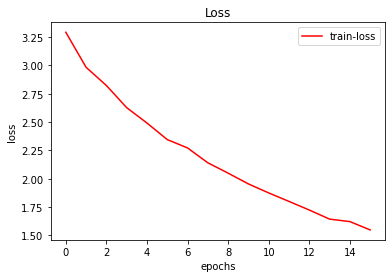

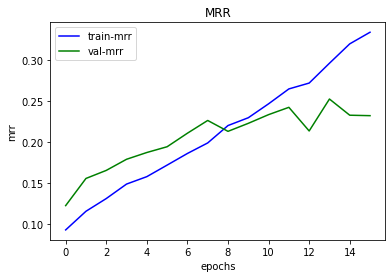

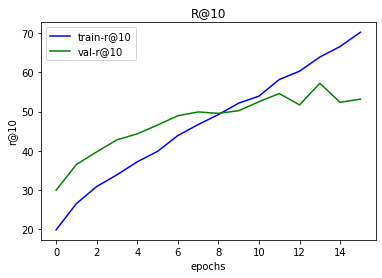

In [ ]:
##############################################################################
# Esta es la parte donde tienes que modificar para poder probar tu 
# implementación. 
# En general sólo es necesario que modifiques los lugares con "...", pero 
# eres libre de hacer tus propias implementaciones de todo lo que aparece.
##############################################################################

BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 16
REPORTS_EVERY = 1
CNN_OUT_SIZE = 1024
EMBEDDING_SIZE = 4096
OUT_SIZE = 512
MARGIN = .2
NEGATIVE = 'max'

cnn_net = GoogLeNet(n_classes=CNN_OUT_SIZE)
img_net = ImageEncoding(cnn_model=cnn_net, cnn_out_size=CNN_OUT_SIZE, 
                        out_size=OUT_SIZE) 

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': img_net.parameters()},  # lista de parametros de img_net
                        {'params': text_net.parameters()}],  # lista de parametros de text_net
                       lr=LR)
criterion = TripletLoss(margin=MARGIN, negative=NEGATIVE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) # (opcional) optim.lr_scheduler proporciona varios métodos 
                # para ajustar el lr según el número de épocas

train_triplets_loader = DataLoader(train_flickr_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_flickr_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                              train_triplets_loader, 
                                              val_triplets_loader, optimizer, 
                                              criterion, scheduler, EPOCHS, 
                                              REPORTS_EVERY, norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')

Correct Test!


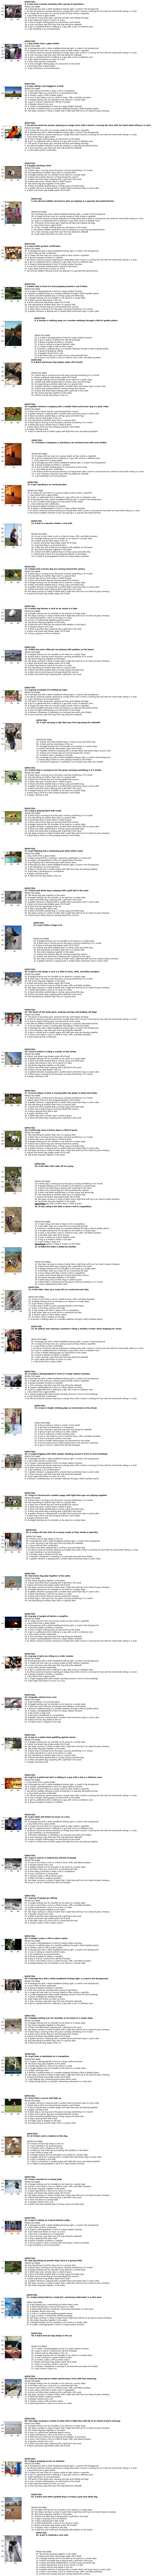

In [ ]:
# Test
from PIL import Image
n_samples = 64

# Tomemos n_samples ejemplos del conjunto de test
samples = torch.stack([test_flickr_tripletset[i][0] for i in range(n_samples)]).cuda()
refs = torch.stack([torch.from_numpy(test_flickr_tripletset[i][1]) for i in range(n_samples)]).cuda()
test_caps = [caps[0] for _, caps in test_flickr_set][:n_samples]

# Computamos las representaciones en el espacio compartido
samples_enc = img_net(samples)['logits']
refs_enc = text_net(refs)['logits']

# Calculemos las distancias a cada uno de los textos de test y rankeamos
dists = torch.cdist(samples_enc.unsqueeze(0), refs_enc.unsqueeze(0), p=2).squeeze(0)
ranks = torch.argsort(dists, dim=1)[:,:10]
r10 = len([i for i in range(len(ranks)) if len(torch.where(ranks[i,:] == i)[0])]) / len(ranks)

# Veamos como se comporta el modelo
print("Correct Test!" if r10 >= .25 else "Failed Test! [R@10]")

# Mostremos las 10 descripciones más cercanas
fig, axs = plt.subplots(nrows=n_samples, figsize=(2,n_samples*5))
for i in range(n_samples):
  axs[i].imshow(Image.open(full_flickr_set.ids[7000+i]))
  axs[i].text(600,0,"EXPECTED:\n{}: {}".format(i, test_caps[i]), fontsize=12, fontweight='bold')
  axs[i].text(600,750,"PREDICTED RANK:\n{}".format('\n'.join([f'{j}: {test_caps[j]}' for j in ranks[i]])), fontsize=12)

## 2d) Opcional: COCO Captions

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para COCO Captions.
##############################################################################

folder_path = './data/coco-caps'
if not os.path.exists(f'{folder_path}/images/train2014'):
  print('\n*** Descargando y extrayendo COCO Captions, siéntese y relájese unos 20 mins...')
  print('****** Descargando training set...\n')
  !wget http://images.cocodataset.org/zips/train2014.zip -P $folder_path/images
  print('\n********* Extrayendo training set...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/train2014.zip -d $folder_path/images && rm $folder_path/images/train2014.zip
  print('\n*** Descargando y extrayendo validation set...\n')
  !wget http://images.cocodataset.org/zips/val2014.zip -P $folder_path/images && unzip -q $folder_path/images/val2014.zip -d $folder_path/images && rm $folder_path/images/val2014.zip
  # !wget http://images.cocodataset.org/zips/test2014.zip -P $folder_path/images && unzip -q $folder_path/images/test2014.zip -d $folder_path/images && rm $folder_path/images/test2014.zip
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P $folder_path && unzip -q $folder_path/annotations_trainval2014.zip -d $folder_path && rm $folder_path/images/annotations_trainval2014.zip

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/train2014',
                                                   annFile = f'{folder_path}/annotations/captions_train2014.json',
                                                   transform=transform)

val_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/val2014',
                                                 annFile = f'{folder_path}/annotations/captions_val2014.json',
                                                 transform=transform)

# test_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/test2014',
#                                                   transform=transform)


*** Descargando y extrayendo COCO Captions, siéntese y relájese unos 20 mins...
****** Descargando training set...

--2020-12-14 03:03:20--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.33.236
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.33.236|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘./data/coco-caps/images/train2014.zip’

train2014.zip       100%[===================>]  12.58G  30.2MB/s    in 5m 9s   

2020-12-14 03:08:30 (41.7 MB/s) - ‘./data/coco-caps/images/train2014.zip’ saved [13510573713/13510573713]


********* Extrayendo training set...
  Si te sale mensaje de colab, dale Ignorar


*** Descargando y extrayendo validation set...

--2020-12-14 03:14:53--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.110.179
Connecting to images.cocodata

In [ ]:
if not os.path.exists(f'{folder_path}/cap_encodings_512d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/cap_encodings_512d.pkl -P $folder_path

with open(f'{folder_path}/cap_encodings_512d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs = pickle.load(f)

train_coco_tripletset = ImageCaptionDataset(train_coco_set, train_cap_encs)
val_coco_tripletset = ImageCaptionDataset(val_coco_set, val_cap_encs)

--2020-12-14 03:20:35--  https://s06.imfd.cl/04/CC6204/tareas/tarea4/cap_encodings_512d.pkl
Resolving s06.imfd.cl (s06.imfd.cl)... 192.80.24.186
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1270535682 (1.2G) [application/octet-stream]
Saving to: ‘./data/coco-caps/cap_encodings_512d.pkl’

cap_encodings_512d.  85%[================>   ]   1.01G  10.1MB/s    in 2m 39s  

2020-12-14 03:23:15 (6.49 MB/s) - Connection closed at byte 1082971972. Retrying.

--2020-12-14 03:23:16--  (try: 2)  https://s06.imfd.cl/04/CC6204/tareas/tarea4/cap_encodings_512d.pkl
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1270535682 (1.2G), 187563710 (179M) remaining [application/octet-stream]
Saving to: ‘./data/coco-caps/cap_encodings_512d.pkl’

cap_encodings_512d. 100%[+++++++++++++++++==>]   1.18G  8.57MB/s    in 23s     

2020-12-14 03

In [ ]:
BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 10
REPORTS_EVERY = 1
CNN_PREV_SIZE = 1024
EMBEDDING_SIZE = 512
OUT_SIZE = 512
MARGIN = .2

cnn_net = GoogLeNet(n_classes=CNN_PREV_SIZE)
img_net = ImageEncoding(cnn_model=cnn_net, cnn_out_size=CNN_PREV_SIZE, 
                        out_size=OUT_SIZE) 

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': img_net.parameters()},
                        {'params': text_net.parameters()}], 
                       lr=LR)
criterion = TripletLoss(margin=MARGIN)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

train_triplets_loader = DataLoader(train_coco_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_coco_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                                     train_triplets_loader, 
                                                     val_triplets_loader, 
                                                     optimizer, criterion,
                                                      scheduler, EPOCHS,
                                                     REPORTS_EVERY, 
                                                     norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')

Epoch:1(82783/82783), lr:0.0001000, Loss:3.10544, Train MRR:0.05 R@10:8.94%, Validating...

RuntimeError: ignored